/opt/miniconda3/envs/mlops_env/lib/python3.10/site-packages/statsforecast/core.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


M5 FORECASTING - BASELINE MODELS (WRMSSE CORRETTO)

[1/5] Caricamento dati...
✓ Train: (58327370, 11)
✓ Eval: (853720, 11)

[2/5] Preparazione dati per statsforecast...
✓ Train SF: (58327370, 3)
✓ Eval SF: (853720, 3)

[3/5] Generazione baseline forecasts...
🚀 Training baseline models...


Forecast: 100%|██████████| 3049/3049 [00:04<00:00, 722.44it/s]


✓ Forecasts: (853720, 5)
  Columns: ['unique_id', 'ds', 'Naive', 'SeasonalNaive', 'HistoricAverage']

[4/5] Preparazione forecasts per WRMSSE...
✓ Serie originali: 30490

Processing Naive...
  Forecast array: (30490, 28)
  Calcolando WRMSSE...
  ✅ WRMSSE: 1.4639

Processing SeasonalNaive...
  Forecast array: (30490, 28)
  Calcolando WRMSSE...
  ✅ WRMSSE: 0.8697

Processing HistoricAverage...
  Forecast array: (30490, 28)
  Calcolando WRMSSE...
  ✅ WRMSSE: 1.6918

WRMSSE BASELINE

📊 BASELINE SCORES:
  Naive               : 1.4639
  SeasonalNaive       : 0.8697
  HistoricAverage     : 1.6918

🏆 Best baseline: SeasonalNaive (0.8697)

🎯 TARGET:

[5/5] Generazione visualizzazioni...
✅ Salvato: 02_baseline_wrmsse_correct.png


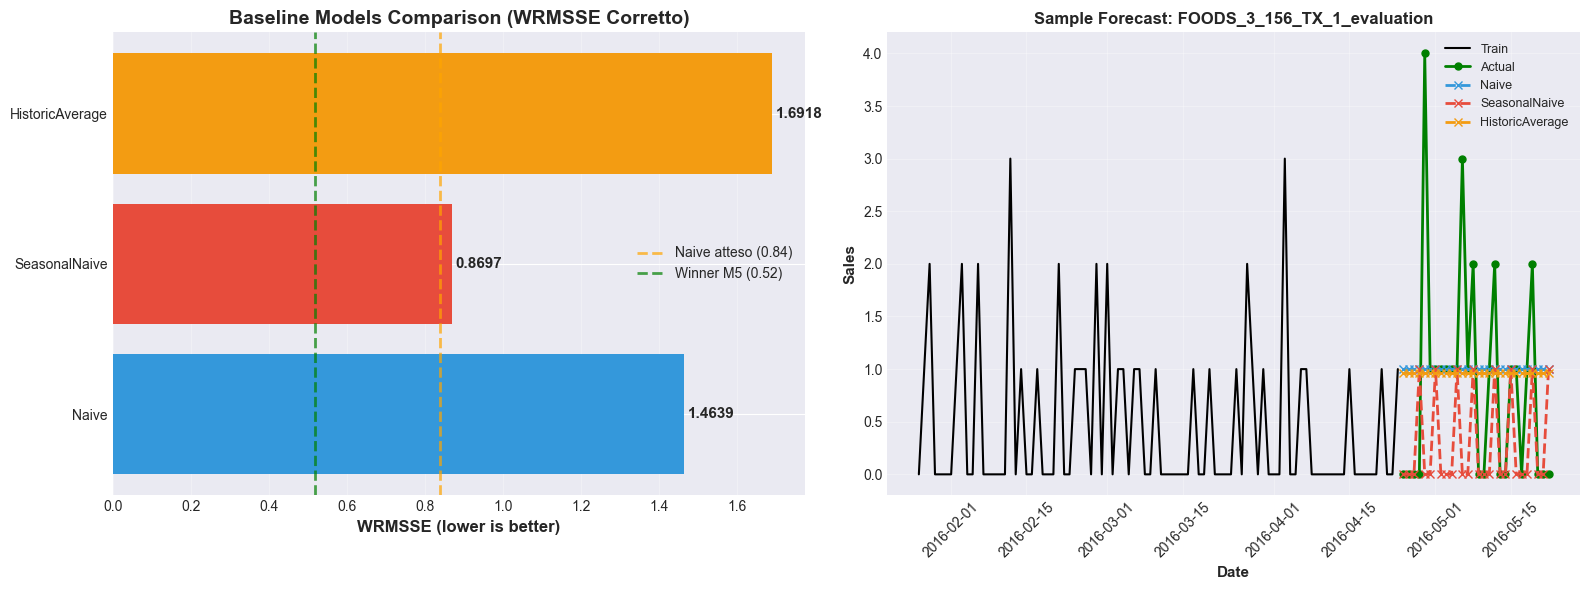


Salvataggio risultati...


In [1]:
# ============================================================================
# Baseline Models
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import warnings
from tqdm import tqdm
from statsforecast import StatsForecast
from statsforecast.models import Naive, SeasonalNaive, HistoricAverage
from m5_wrmsse import wrmsse
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')

# ============================================================================
# 1. SETUP
# ============================================================================

print("="*80)
print("M5 FORECASTING - BASELINE MODELS (WRMSSE CORRETTO)")
print("="*80)

DATA_DIR = Path("../data/processed")
RAW_DIR = Path("../data/raw")
OUTPUT_DIR = Path("../data/baseline_results")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# ============================================================================
# 2. CARICA DATI
# ============================================================================

print("\n[1/5] Caricamento dati...")

with open(DATA_DIR / "train_official.pkl", 'rb') as f:
    train = pickle.load(f)
with open(DATA_DIR / "eval_official.pkl", 'rb') as f:
    eval_data = pickle.load(f)

print(f"✓ Train: {train.shape}")
print(f"✓ Eval: {eval_data.shape}")

# ============================================================================
# 3. PREPARA DATI PER STATSFORECAST
# ============================================================================

print("\n[2/5] Preparazione dati per statsforecast...")

# Format per statsforecast
train_sf = train[['id', 'date', 'sales']].copy()
train_sf.columns = ['unique_id', 'ds', 'y']

eval_sf = eval_data[['id', 'date', 'sales']].copy()
eval_sf.columns = ['unique_id', 'ds', 'y']

print(f"✓ Train SF: {train_sf.shape}")
print(f"✓ Eval SF: {eval_sf.shape}")

# ============================================================================
# 4. BASELINE FORECASTS
# ============================================================================

print("\n[3/5] Generazione baseline forecasts...")

# Modelli baseline
models = [
    Naive(),
    SeasonalNaive(season_length=7),
    HistoricAverage()
]

# Crea forecaster
sf = StatsForecast(
    models=models,
    freq='D',
    n_jobs=-1
)

print("🚀 Training baseline models...")

# Forecast
forecasts = sf.forecast(df=train_sf, h=28)
forecasts = forecasts.reset_index()

print(f"✓ Forecasts: {forecasts.shape}")
print(f"  Columns: {forecasts.columns.tolist()}")

# ============================================================================
# 5. PREPARA FORMATO PER m5_wrmsse
# ============================================================================

print("\n[4/5] Preparazione forecasts per WRMSSE...")

# Carica ordine originale delle serie
sales_orig = pd.read_csv(RAW_DIR / "sales_train_evaluation.csv")
series_order = sales_orig['id'].tolist()

print(f"✓ Serie originali: {len(series_order)}")

# Per ogni modello, crea submission format
results = {}

for model_name in ['Naive', 'SeasonalNaive', 'HistoricAverage']:
    print(f"\nProcessing {model_name}...")
    
    # Pivot forecasts
    forecast_pivot = forecasts[['unique_id', model_name]].copy()
    
    # Reset per avere giorni come indice
    forecast_pivot['day'] = forecasts.groupby('unique_id').cumcount() + 1
    forecast_pivot = forecast_pivot.pivot(
        index='unique_id',
        columns='day',
        values=model_name
    )
    
    # Riordina per matchare series_order
    forecast_pivot = forecast_pivot.reindex(series_order)
    
    # Converti in numpy array (30490, 28)
    forecast_array = forecast_pivot.values
    
    print(f"  Forecast array: {forecast_array.shape}")
    
    # Calcola WRMSSE
    print(f"  Calcolando WRMSSE...")
    wrmsse_score = wrmsse(forecast_array)
    
    results[model_name] = {
        'wrmsse': wrmsse_score,
        'forecasts': forecast_pivot
    }
    
    print(f"  ✅ WRMSSE: {wrmsse_score:.4f}")

# ============================================================================
# 6. RISULTATI
# ============================================================================

print("\n" + "="*80)
print("WRMSSE BASELINE")
print("="*80)

print(f"\n📊 BASELINE SCORES:")
for model_name, result in results.items():
    print(f"  {model_name:20s}: {result['wrmsse']:.4f}")

best_model = min(results.keys(), key=lambda k: results[k]['wrmsse'])
best_wrmsse = results[best_model]['wrmsse']

print(f"\n🏆 Best baseline: {best_model} ({best_wrmsse:.4f})")
print(f"\n🎯 TARGET:")

# ============================================================================
# 7. VISUALIZZAZIONI
# ============================================================================

print("\n[5/5] Generazione visualizzazioni...")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Confronto modelli
ax1 = axes[0]
model_names = list(results.keys())
scores = [results[m]['wrmsse'] for m in model_names]

bars = ax1.barh(model_names, scores, color=['#3498db', '#e74c3c', '#f39c12'])
ax1.axvline(x=0.84, color='orange', linestyle='--', linewidth=2, 
           label='Naive atteso (0.84)', alpha=0.7)
ax1.axvline(x=0.52, color='green', linestyle='--', linewidth=2, 
           label='Winner M5 (0.52)', alpha=0.7)

ax1.set_xlabel('WRMSSE (lower is better)', fontsize=12, fontweight='bold')
ax1.set_title('Baseline Models Comparison (WRMSSE Corretto)', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(alpha=0.3, axis='x')

for i, v in enumerate(scores):
    ax1.text(v + 0.01, i, f'{v:.4f}', va='center', fontweight='bold', fontsize=11)

# Plot 2: Sample forecasts
ax2 = axes[1]

# Prendi una serie random
sample_id = np.random.choice(series_order)
sample_train = train_sf[train_sf['unique_id'] == sample_id].tail(90)
sample_eval = eval_sf[eval_sf['unique_id'] == sample_id]

ax2.plot(sample_train['ds'], sample_train['y'], 
        label='Train', color='black', linewidth=1.5)
ax2.plot(sample_eval['ds'], sample_eval['y'], 
        label='Actual', color='green', linewidth=2, marker='o', markersize=5)

# Plot forecasts
colors_models = {'Naive': '#3498db', 'SeasonalNaive': '#e74c3c', 'HistoricAverage': '#f39c12'}
for model_name in results.keys():
    forecast_vals = results[model_name]['forecasts'].loc[sample_id].values
    ax2.plot(sample_eval['ds'], forecast_vals, 
            label=model_name, linestyle='--', linewidth=2, 
            color=colors_models[model_name], marker='x')

ax2.set_xlabel('Date', fontsize=11, fontweight='bold')
ax2.set_ylabel('Sales', fontsize=11, fontweight='bold')
ax2.set_title(f'Sample Forecast: {sample_id}', fontsize=12, fontweight='bold')
ax2.legend(loc='best', fontsize=9)
ax2.grid(alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / '02_baseline_wrmsse_correct.png', dpi=150, bbox_inches='tight')
print("✅ Salvato: 02_baseline_wrmsse_correct.png")
plt.show()

# ============================================================================
# 8. SALVATAGGIO
# ============================================================================

print("\nSalvataggio risultati...")

# Salva forecasts
for model_name, result in results.items():
    result['forecasts'].to_pickle(OUTPUT_DIR / f'{model_name.lower()}_forecasts.pkl')

# Summary
summary = {
    'naive_wrmsse': results['Naive']['wrmsse'],
    'seasonal_naive_wrmsse': results['SeasonalNaive']['wrmsse'],
    'historic_avg_wrmsse': results['HistoricAverage']['wrmsse'],
    'best_model': best_model,
    'best_wrmsse': best_wrmsse,
    'target_1_reached': best_wrmsse < 1.0,
    'target_06_reached': best_wrmsse < 0.6
}

with open(OUTPUT_DIR / 'baseline_summary.pkl', 'wb') as f:
    pickle.dump(summary, f)